In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from transformers import BertTokenizer, TFBertModel
import sentencepiece as spm
import utils

In [18]:
!ls

DataProcessing.ipynb      README.md                 corpus-webis-tldr-17.json


In [19]:
!head -1 corpus-webis-tldr-17.json | jq 'keys'

[
  "author",
  "body",
  "content",
  "content_len",
  "id",
  "normalizedBody",
  "subreddit",
  "subreddit_id",
  "summary",
  "summary_len"
]


In [20]:
!head -1 corpus-webis-tldr-17.json

{"author":"raysofdarkmatter","body":"I think it should be fixed on either UTC standard or UTC+1 year around, with the current zone offsets.\n\nMoving timescales add a lot of complexity to the implementation of timekeeping systems and have [dubious value]( \n\nI think seasonal shifting time made sense in the pre-electric past, when timekeeping was more flexible and artificial light was inefficient and often dangerous. \n\nNow we have machines that work easily with simple timekeeping rules, and it's more beneficial to spend a small amount on energy for lighting, and save the larger cost of engineering things to work with the complex timekeeping rules, as well as saving the irritation to humans.\n\nLighting has gotten much more efficient over time; we can squeeze out a lot more photons per unit of energy from a 2012 CFL or LED than a candle could in 1780, or a lightbulb could in 1950. \n\nThere's a lot of room for improvement in how we use lights as well; as lighting control gets more int

In [5]:
reddit_posts = []
with open('corpus-webis-tldr-17.json', 'r') as f:
    for i, line in enumerate(f):
        post = json.loads(line)
        del post['body']
        del post['normalizedBody']
        reddit_posts.append(post)
        if i % 10**6 == 0:
            print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000


In [6]:
# [p for p in reddit_posts if p['subreddit'] == 'Borderlands']
subreddits = Counter()
missing = 0
for p in reddit_posts:
    if 'subreddit' not in p:
        missing+=1
    else:
        subreddits[p['subreddit']] += 1

In [7]:
# number of posts missing a subreddit
missing

136

In [16]:
# total number of subreddits in the dataset
len(subreddits)

29650

In [42]:
# 100 most common subreddits in the dataset
top_100 = set([k for k, v in subreddits.most_common(100)])
subreddits.most_common(100)

[('AskReddit', 589947),
 ('relationships', 352049),
 ('leagueoflegends', 109307),
 ('tifu', 52219),
 ('relationship_advice', 50416),
 ('trees', 47286),
 ('gaming', 43851),
 ('atheism', 43268),
 ('AdviceAnimals', 40783),
 ('funny', 40171),
 ('politics', 36518),
 ('pics', 35098),
 ('sex', 28806),
 ('WTF', 25781),
 ('explainlikeimfive', 25482),
 ('todayilearned', 25004),
 ('Fitness', 22694),
 ('IAmA', 22689),
 ('worldnews', 22577),
 ('DotA2', 22405),
 ('TwoXChromosomes', 21562),
 ('videos', 20567),
 ('DestinyTheGame', 19878),
 ('reddit.com', 19020),
 ('offmychest', 17175),
 ('buildapc', 14817),
 ('AskMen', 14538),
 ('personalfinance', 14403),
 ('summonerschool', 13806),
 ('technology', 13700),
 ('wow', 13309),
 ('NoFap', 13203),
 ('starcraft', 12911),
 ('dating_advice', 12361),
 ('askscience', 12037),
 ('Games', 11820),
 ('news', 11660),
 ('talesfromtechsupport', 11537),
 ('depression', 11365),
 ('pcmasterrace', 11348),
 ('Guildwars2', 10948),
 ('magicTCG', 10624),
 ('loseit', 10559),
 ('

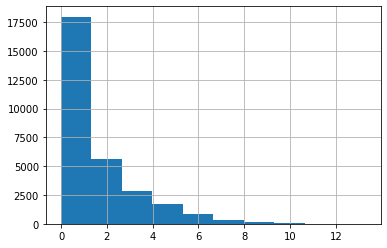

In [15]:
subreddit_counts = pd.Series(list(subreddits.values()))
np.log(subreddit_counts).hist()
# np.log(subreddit_counts).hist(cumulative=True)

In [2]:
sp = spm.SentencePieceProcessor(model_file="../pegasus/ckpt/pegasus_ckpt/c4.unigram.newline.10pct.96000.model")
sp.vocab_size()

96000

In [24]:
sp.bos_id()

-1

In [5]:
sp.decode([1])

''

In [25]:
sp.piece_to_id('<pad>')

0

In [4]:
sp.unk_id()

2

In [23]:
for t in utils.top50subreddits[:50]:
    print(sp.encode(t, out_type=str))

['▁Ask', 'Red', 'dit']
['▁relationships']
['▁league', 'of', 'legend', 's']
['▁ti', 'fu']
['▁relationship', '_', 'advice']
['▁trees']
['▁gaming']
['▁atheism']
['▁Advice', 'Animal', 's']
['▁funny']
['▁politics']
['▁pics']
['▁sex']
['▁WTF']
['▁explain', 'like', 'im', 'five']
['▁today', 'i', 'learned']
['▁Fitness']
['▁I', 'Am', 'A']
['▁world', 'news']
['▁Dot', 'A', '2']
['▁Two', 'X', 'Ch', 'rom', 'osomes']
['▁videos']
['▁Destiny', 'The', 'Game']
['▁reddit', '.', 'com']
['▁off', 'my', 'chest']
['▁build', 'a', 'pc']
['▁Ask', 'Men']
['▁personal', 'finance']
['▁summon', 'er', 'school']
['▁technology']
['▁wow']
['▁No', 'F', 'ap']
['▁star', 'craft']
['▁dating', '_', 'advice']
['▁ask', 'science']
['▁Games']
['▁news']
['▁tales', 'from', 'tech', 'support']
['▁depression']
['▁pc', 'master', 'race']
['▁Guild', 'war', 's', '2']
['▁magic', 'TC', 'G']
['▁lose', 'it']
['▁Global', 'Off', 'ensi', 've']
['▁electronic', '_', 'cigarette']
['▁movies']
['▁self']
['▁Advice']
['▁Drugs']
['▁teenagers']


In [49]:
num_unk = []
unknowns = Counter()
top_100_subreddit_posts = list(filter(lambda x: 'subreddit' in x and x['subreddit'] in top_100, reddit_posts))
print(len(top_100_subreddit_posts))

for i, post in enumerate(top_100_subreddit_posts[:100000]):
    if post['subreddit'] in top_100:
        encoded = sp.encode(post['content'])
        unks = [i for i, p in enumerate(encoded) if p==sp.unk_id()]
        if c > 0:
            pieces = sp.encode(post['content'], out_type=str)
            unknowns += Counter([pieces[i] for i in unks])
        num_unk.append(c / len(encoded))

2382081


In [51]:
unknowns.most_common(100)

[('~', 1744),
 ('<', 1559),
 ('^', 1334),
 ('\\', 220),
 ('́', 192),
 ('^^', 158),
 ('`', 154),
 ('}', 124),
 ('{', 123),
 ('°', 118),
 ('€', 104),
 ('ö', 68),
 ('~~', 66),
 ('ಠ', 49),
 ('±', 46),
 ('ü', 45),
 ('ñ', 44),
 ('ä', 41),
 ('ó', 40),
 ('→', 39),
 ('×', 37),
 ('á', 36),
 ('à', 36),
 ('ø', 33),
 ('ï', 31),
 ('í', 30),
 ('æ', 30),
 ('§', 28),
 ('ð', 25),
 ('͇', 25),
 ('è', 25),
 ('·', 24),
 ('φ', 24),
 ('»', 21),
 ('Ω', 21),
 ('⟩', 21),
 ('«', 20),
 ('с', 20),
 ('ú', 18),
 ('ω', 18),
 ('−', 18),
 ('⁄', 17),
 ('å', 17),
 ('ç', 16),
 ('``', 16),
 ('}{', 15),
 ('ō', 13),
 ('^^^', 13),
 ('Δ', 13),
 ('ē', 12),
 ('^^^^^', 12),
 ('š', 11),
 ('μ', 11),
 ('ê', 11),
 ('Ø', 10),
 ('ò', 10),
 ('¢', 9),
 ('∆', 9),
 ('É', 8),
 ('≥', 8),
 ('þ', 8),
 ('^{', 8),
 ('\\^', 7),
 ('ā', 7),
 ('ë', 7),
 ('ß', 7),
 ('ã', 7),
 ('►', 7),
 ('⟨', 7),
 ('к', 6),
 ('λ', 6),
 ('¥', 6),
 ('‐', 6),
 ('Þ', 5),
 ('͇^', 5),
 ('√', 5),
 ('Ук', 5),
 ('α', 5),
 ('й', 5),
 ('п', 5),
 ('β', 5),
 ('÷', 5),
 ('―', 5),
 

In [54]:
sum([n==0 for n in num_unk]) / len(num_unk)

0.0

In [56]:
min(num_unk)

0.00036403349108117945